In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from diffusers import DDIMScheduler
import json

try:
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *
except ModuleNotFoundError:
    import os; os.chdir("..")
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Get a memorized sample


In [ ]:
# load model
torch.cuda.set_device(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_id = "CompVis/stable-diffusion-v1-4"

pipe = LocalStableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

In [52]:
num_inference_steps = 50
guidance_scale = 7.5
num_images_per_prompt = 4
image_size = 512
seed=0
# prompt = "The No Limits Business Woman Podcast"
# prompt = "A painting of the Great Wave off Kanagawa by Katsushika Hokusai"
# prompt = "Netflix Hits 50 Million Subscribers"
prompt = "Sony won't release The Interview on VOD"

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 12.41it/s]


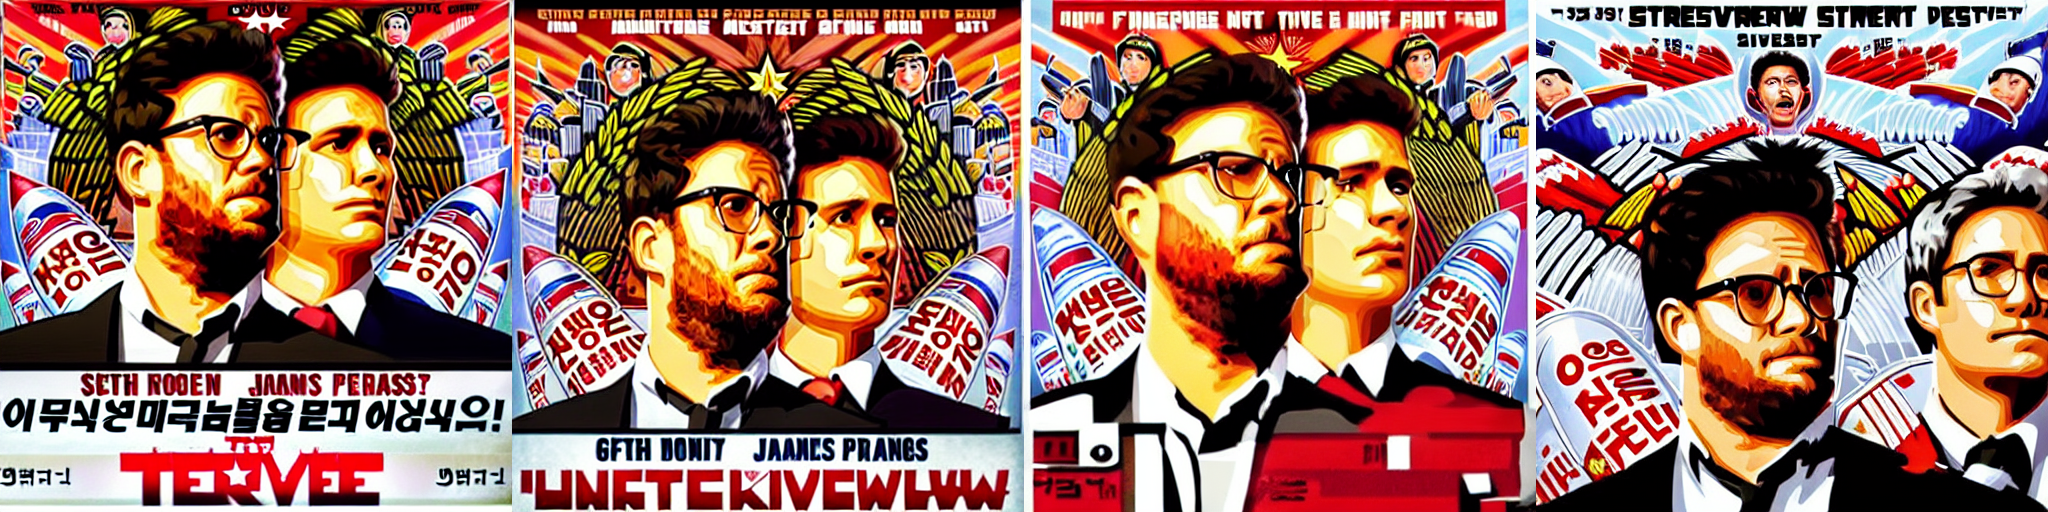

In [53]:
from visualization.images import image_grid

set_random_seed(seed)

outputs, track_stats = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
)
outputs = outputs.images
img = image_grid(outputs, rows=1, cols=num_images_per_prompt)
img.save(f"figures/samples_{prompt.replace(' ', '_')}.png")
display(img)


# Get the Contributions


In [54]:
%matplotlib inline
set_random_seed(seed)
method = "score_norm"
contributions = {}
for method in ["score_norm", "cfg_norm", "flipd"]:
    token_grads = pipe.get_text_cond_grad(
        prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        num_images_per_prompt=1 if method == "flipd" else num_images_per_prompt,
        target_steps=list(range(10, 50)) if method == "flipd" else list(range(50)) ,
        method=method,
    )
    torch.cuda.empty_cache()

    prompt_tokens = pipe.tokenizer.encode(prompt)
    prompt_tokens = prompt_tokens[1:-1]
    prompt_tokens = prompt_tokens[:75]
    token_grads = token_grads[1:(1+len(prompt_tokens))]
    token_grads = token_grads.cpu().tolist()

    all_tokes = []

    for curr_token in prompt_tokens:
        all_tokes.append(pipe.tokenizer.decode(curr_token))

    contributions[method] = token_grads

  4%|▍         | 2/50 [00:00<00:08,  5.70it/s]

 98%|█████████▊| 49/50 [00:28<00:00,  1.75it/s]


# Visualize Everything


<Axes: >

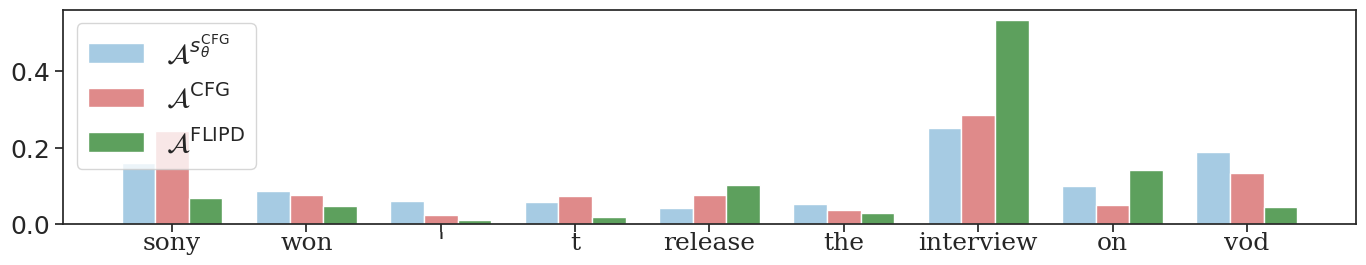

In [55]:
from visualization.histograms import plot_bars, plot_bars_raw
from visualization.pretty import ColorTheme
import matplotlib.pyplot as plt


plot_bars(
    label_distance=-0.02,
    bar_width = 0.25,
    x_values = all_tokes,
    group_bar_values = [
        np.array(contributions["score_norm"]) / sum(contributions["score_norm"]),
        np.array(contributions["cfg_norm"]) / sum(contributions["cfg_norm"]),
        np.array(contributions["flipd"]) / sum(contributions["flipd"]),
    ],
    group_labels = [
        "$\\mathcal{A}^{s_\\theta^\\text{CFG}}$",
        "$\\mathcal{A}^{\\text{CFG}}$",
        "$\\mathcal{A}^{\\text{FLIPD}}$",
    ],
    group_colors= [
        ColorTheme.BLUE_SECOND.value,
        ColorTheme.RED_SECOND.value,
        ColorTheme.GREEN.value,
    ],
    figsize = (14, 3),
    y_label=None,
    file_name=f"token_attributions_{prompt.replace(' ', '_')}",
    transparent_save=True,
    tick_fontsize=18,
    legend_fontsize=20,
    legend_loc="upper left",
    no_hashlines=True, 
)